# TF-IDF Unsupervised Recommender Example
<i>Facililated by Josh Mason and Yousif Mansour, 9/22/2023</i>

In [ ]:
# TODO: sqlalchemy stuff
from sqlalchemy import create_engine
import pandas as pd

db_url = 'your_database_url'
engine = create_engine(db_url)

query = 'SELECT * FROM your_table'
df = pd.read_sql(query, engine)

engine.dispose()

This notebook is part of our preliminary algorithm research phase. 

At this point in the project, we have decided to stick with TF-IDF as it's the only purely unsupervised model availabe in Microsoft Recommenders.

### 1. Load the Metadata from our local test file

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from recommenders.models.tfidf.tfidf_utils import TfidfRecommender
import pickle

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [2]:
metadata = pd.read_csv(Path("mock_data/mock_data_v3.csv")) 
metadata.head()

,UID,Name,Topic,Summary,Description,Tags,Feature_Names,Length,Size,Source,License,Usability
0,1,Football Stats,Sports,A comprehensive dataset containing statistics ...,This dataset provides detailed statistics for ...,"Football, Soccer, Sports Analytics","Player, Team, Match, Goals, Assists, Yellow Ca...",5000,2456 KB,Kaggle,CC BY-SA 4.0,9.2
1,2,NBA Player Stats,Sports,A dataset containing statistics for NBA player...,This dataset provides detailed statistics for ...,"Basketball, NBA, Sports Analytics","Player, Points, Rebounds, Assists, Steals, Blocks",2500,1897 KB,NBA.com,CC BY-NC-SA 4.0,9.5
2,3,Olympic Games Data,Sports,A dataset containing historical data of Olympi...,This comprehensive dataset contains historical...,"Olympics, Sports History, Medal Counts","Year, Host City, Country, Athlete, Sport, Medal",12000,3689 KB,International Olympic Committee,Public Domain,8.8
3,4,Baseball Player Performance,Sports,An extensive dataset with performance statisti...,This dataset offers a comprehensive collection...,"Baseball, MLB, Sports Analytics","Player, Batting Average, Home Runs, ERA, Wins,...",3500,2874 KB,MLB.com,CC BY-NC-SA 4.0,9.3
4,5,Soccer World Cup,Sports,A dataset containing historical records of FIF...,This dataset contains historical records of FI...,"Soccer, FIFA World Cup, Sports History","Year, Host Country, Match, Score, Teams, Goals...",3000,2145 KB,FIFA.com,Public Domain,8.9


In [3]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   UID            50 non-null     int64  
 1   Name           50 non-null     object 
 2   Topic          50 non-null     object 
 3   Summary        50 non-null     object 
 4   Description    50 non-null     object 
 5   Tags           50 non-null     object 
 6   Feature_Names  50 non-null     object 
 7   Length         50 non-null     int64  
 8   Size           50 non-null     object 
 9   Source         50 non-null     object 
 10  License        50 non-null     object 
 11  Usability      50 non-null     float64
dtypes: float64(1), int64(2), object(9)
memory usage: 4.8+ KB


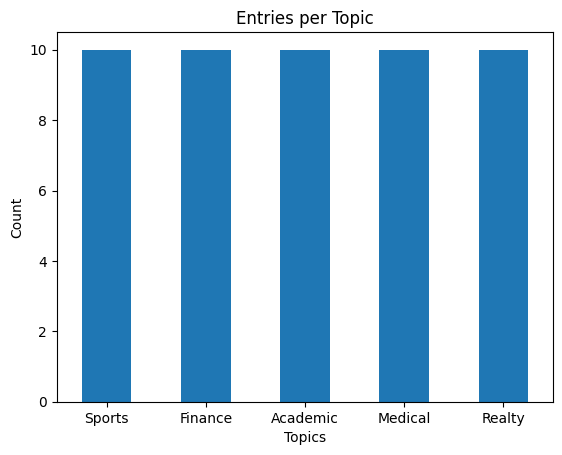

In [4]:
topic_counts = metadata['Topic'].value_counts()

topic_counts.plot(kind='bar')
plt.title('Entries per Topic')
plt.xlabel('Topics')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

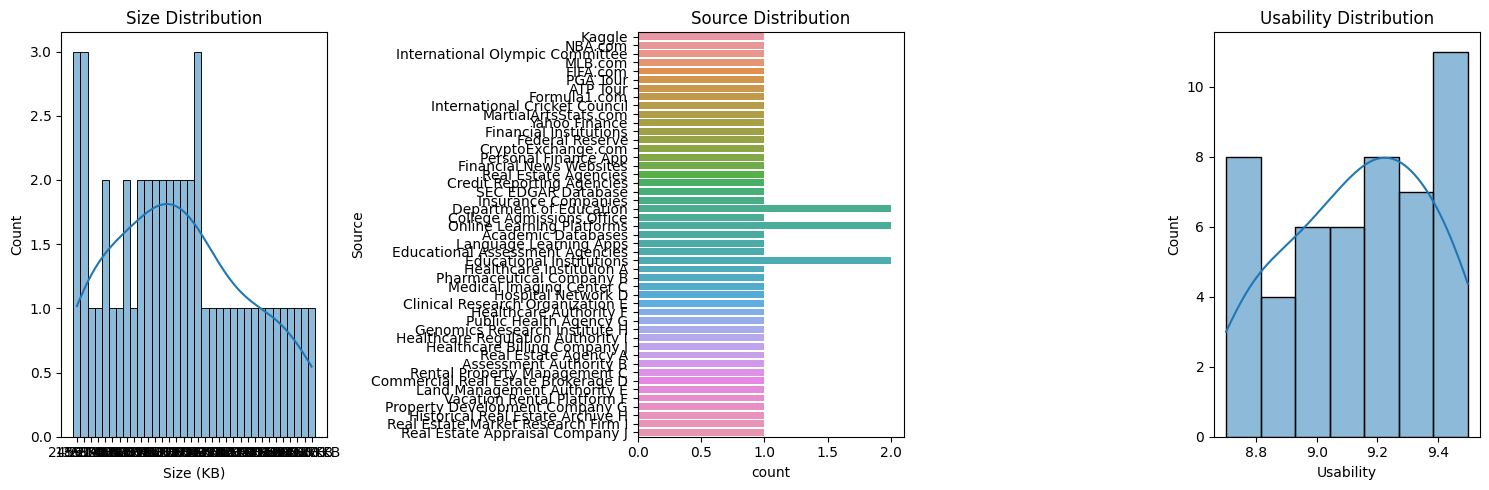

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# Size plot
sns.histplot(data=metadata, x='Size', kde=True, ax=axes[0])
axes[0].set_title('Size Distribution')
axes[0].set_xlabel('Size (KB)')

# Source plot
sns.countplot(data=metadata, y='Source', ax=axes[1])
axes[1].set_title('Source Distribution')
axes[1].set_ylabel('Source')

# Usability plot
sns.histplot(data=metadata, x='Usability', kde=True, ax=axes[2])
axes[2].set_title('Usability Distribution')
axes[2].set_xlabel('Usability')

plt.tight_layout()
plt.show()

In [6]:
all_tags = metadata['Tags'].tolist()
all_tags = [tag for tags_list in all_tags for tag in tags_list]
unique = set(all_tags)
num_tags= len(unique)

print(f"Number of unique tags: {num_tags}")

Number of unique tags: 51


### 2. Instantiate the recommender

These are the following tokenization methods available out-of-the-box with this implementation:

| tokenization_method | Description                                                                                                                      |
|:--------------------|:---------------------------------------------------------------------------------------------------------------------------------|
| 'none'              | No tokenization is applied. Each word is considered a token.                                                                     |
| 'nltk'              | Simple stemming is applied using NLTK.                                                                                           |
| 'bert'              | HuggingFace BERT word tokenization ('bert-base-cased') is applied.                                                               |
| 'scibert'           | SciBERT word tokenization ('allenai/scibert_scivocab_cased') is applied.<br>This is recommended for scientific journal articles. |

<i>Source: [Microsoft Recommender](https://github.com/recommenders-team/recommenders/blob/main/examples/00_quick_start/tfidf_covid.ipynb)</i>

In [7]:
recommender = TfidfRecommender(id_col='UID', tokenization_method='scibert')

### 3. Prepare text for use in the TF-IDF model

Here we will...

In [8]:
# Assign columns to clean and combine
metadata = metadata.astype(str) # combined columns have to all be strings

# For now, we will use all columns except the UID
cols_to_clean = metadata.columns.tolist()
cols_to_clean.remove("UID") 

clean_col = 'cleaned_text'
df_clean = recommender.clean_dataframe(metadata, cols_to_clean, clean_col)
df_clean.head()

,UID,Name,Topic,Summary,Description,Tags,Feature_Names,Length,Size,Source,License,Usability,cleaned_text
0,1,Football Stats,Sports,A comprehensive dataset containing statistics ...,This dataset provides detailed statistics for ...,"Football, Soccer, Sports Analytics","Player, Team, Match, Goals, Assists, Yellow Ca...",5000,2456 KB,Kaggle,CC BY-SA 4.0,9.2,Football Stats Sports A comprehensive dataset ...
1,2,NBA Player Stats,Sports,A dataset containing statistics for NBA player...,This dataset provides detailed statistics for ...,"Basketball, NBA, Sports Analytics","Player, Points, Rebounds, Assists, Steals, Blocks",2500,1897 KB,NBA.com,CC BY-NC-SA 4.0,9.5,NBA Player Stats Sports A dataset containing s...
2,3,Olympic Games Data,Sports,A dataset containing historical data of Olympi...,This comprehensive dataset contains historical...,"Olympics, Sports History, Medal Counts","Year, Host City, Country, Athlete, Sport, Medal",12000,3689 KB,International Olympic Committee,Public Domain,8.8,Olympic Games Data Sports A dataset containing...
3,4,Baseball Player Performance,Sports,An extensive dataset with performance statisti...,This dataset offers a comprehensive collection...,"Baseball, MLB, Sports Analytics","Player, Batting Average, Home Runs, ERA, Wins,...",3500,2874 KB,MLB.com,CC BY-NC-SA 4.0,9.3,Baseball Player Performance Sports An extensiv...
4,5,Soccer World Cup,Sports,A dataset containing historical records of FIF...,This dataset contains historical records of FI...,"Soccer, FIFA World Cup, Sports History","Year, Host Country, Match, Score, Teams, Goals...",3000,2145 KB,FIFA.com,Public Domain,8.9,Soccer World Cup Sports A dataset containing h...


In [46]:
# Tokenize text with tokenization_method specified in class instantiation
tf, vectors_tokenized = recommender.tokenize_text(df_clean, text_col=clean_col)

### 4. Recommend articles using TF-IDF

In [47]:
# Fit the TF-IDF vectorizer
recommender.fit(tf, vectors_tokenized)

# Get recommendations
top_k_recommendations = recommender.recommend_top_k_items(df_clean, k=10)

In [ ]:
# Serialize model
model_path = Path("../backend/models/model.pkl")
with open(model_path, 'wb') as file:
    pickle.dump(recommender, file)

In our recommendation table, each row represents a single recommendation.

- **UID** corresponds to the article that is being used to make recommendations from.
- **rec_rank** contains the recommdation's rank (e.g., rank of 1 means top recommendation).
- **rec_score** is the cosine similarity score between the query article and the recommended article.
- **rec_cord_uid** corresponds to the recommended article.

In [48]:
# Preview the recommendations
top_k_recommendations

,UID,rec_rank,rec_score,rec_UID
0,1,1,0.146816,2
1,1,2,0.135913,4
2,1,3,0.099835,5
3,1,4,0.097630,6
4,1,5,0.079132,8
...,...,...,...,...
495,50,6,0.187824,49
496,50,7,0.143809,47
497,50,8,0.136324,43
498,50,9,0.063134,46


In [49]:
# view full recommendation list
full_rec_list = recommender.recommendations

article_of_interest = '1'
print('Number of recommended articles for ' + article_of_interest + ': ' + str(len(full_rec_list[article_of_interest])))

Number of recommended articles for 1: 49


In [50]:
metadata[metadata.UID == "1"]

,UID,Name,Topic,Summary,Description,Tags,Feature_Names,Length,Size,Source,License,Usability
0,1,Football Stats,Sports,A comprehensive dataset containing statistics ...,This dataset provides detailed statistics for ...,"Football, Soccer, Sports Analytics","Player, Team, Match, Goals, Assists, Yellow Ca...",5000,2456 KB,Kaggle,CC BY-SA 4.0,9.2


In [51]:
# Optionally view tokens
tokens = recommender.get_tokens()
# Preview 10 tokens
print(list(tokens.keys())[:10])
# Preview just the first 10 stop words sorted alphabetically
stop_words = list(recommender.get_stop_words())
stop_words.sort()
print(stop_words[:10])

['foot', 'ball', 'stat', 'sports', 'comprehensive', 'dataset', 'containing', 'statistics', 'matches', 'including']
['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost']


In [52]:
# Final Recs
cols_to_keep = cols_to_clean
recommender.get_top_k_recommendations(metadata,article_of_interest,cols_to_keep)
# TODO: why cant display UID??

,rank,similarity_score,Name,Topic,Summary,Description,Tags,Feature_Names,Length,Size,Source,License,Usability
0,1,0.146816,NBA Player Stats,Sports,A dataset containing statistics for NBA player...,This dataset provides detailed statistics for ...,"Basketball, NBA, Sports Analytics","Player, Points, Rebounds, Assists, Steals, Blocks",2500,1897 KB,NBA.com,CC BY-NC-SA 4.0,9.5
1,2,0.135913,Baseball Player Performance,Sports,An extensive dataset with performance statisti...,This dataset offers a comprehensive collection...,"Baseball, MLB, Sports Analytics","Player, Batting Average, Home Runs, ERA, Wins,...",3500,2874 KB,MLB.com,CC BY-NC-SA 4.0,9.3
2,3,0.099835,Soccer World Cup,Sports,A dataset containing historical records of FIF...,This dataset contains historical records of FI...,"Soccer, FIFA World Cup, Sports History","Year, Host Country, Match, Score, Teams, Goals...",3000,2145 KB,FIFA.com,Public Domain,8.9
3,4,0.097630,Golf Tournament Results,Sports,A dataset with results and statistics from pro...,This dataset provides results and statistics f...,"Golf, PGA Tour, Sports Analytics","Player, Tournament, Score, Course, Par, Rank",1800,1456 KB,PGA Tour,CC BY-NC-SA 4.0,9.1
4,5,0.079132,Formula 1 Racing Data,Sports,A dataset containing statistics and results fr...,This dataset provides comprehensive statistics...,"Formula 1, Racing, Sports Analytics","Race, Year, Driver, Team, Circuit, Points",2000,1765 KB,Formula1.com,CC BY-NC-SA 4.0,9.2
5,6,0.073743,Tennis Grand Slam Data,Sports,A dataset containing information about Grand S...,This dataset offers comprehensive information ...,"Tennis, Grand Slam, Sports Analytics","Tournament, Year, Player, Match, Score, Rank",2500,1892 KB,ATP Tour,CC BY-NC-SA 4.0,9.4
6,7,0.061417,Cricket Match Records,Sports,A dataset containing records of international ...,This dataset contains records of international...,"Cricket, Sports Analytics, International Matches","Match, Year, Teams, Score, Player, Runs, Wickets",2800,2098 KB,International Cricket Council,CC BY-NC-SA 4.0,8.8
7,8,0.034576,Martial Arts Tournament Data,Sports,A dataset containing information about martial...,This dataset offers comprehensive information ...,"Martial Arts, MMA, Boxing, Sports Analytics","Event, Date, Fighters, Match, Result, Discipline",1500,1323 KB,MartialArtsStats.com,CC BY-NC-SA 4.0,9.0
8,9,0.022605,Medical Imaging Dataset,Medical,"A dataset containing medical images, including...","This dataset includes medical images, such as ...","Medical Imaging, Radiology, Diagnostic Research","Image ID, Modality, Patient Information, Imagi...",5000,2456 KB,Medical Imaging Center C,CC BY-SA 4.0,9.4
9,10,0.019772,Real Estate Market Indices,Realty,A dataset containing real estate market indice...,This dataset comprises real estate market indi...,"Real Estate Market, Price Indices, Rental Indices","Index ID, Property Type, Price Index, Rental I...",4500,1987 KB,Real Estate Market Research Firm I,CC BY-SA 4.0,9.2


In [53]:
full_rec_list

{'1': [(0.1468160851392342, '2'),
  (0.1359126015351822, '4'),
  (0.09983522742920584, '5'),
  (0.09763022228914314, '6'),
  (0.07913184161330096, '8'),
  (0.07374285570465379, '7'),
  (0.061417411373365406, '9'),
  (0.03457619216149142, '10'),
  (0.022604881033718802, '33'),
  (0.019772308034270332, '49'),
  (0.019490744915321295, '21'),
  (0.019205428741174337, '11'),
  (0.018812769330634804, '17'),
  (0.01738853007945406, '41'),
  (0.015163072132233038, '12'),
  (0.014884828792053377, '31'),
  (0.014814132545724761, '22'),
  (0.014340242885032096, '29'),
  (0.013982145142032087, '50'),
  (0.01253261533495018, '36'),
  (0.012315028111303786, '3'),
  (0.011153193479166839, '27'),
  (0.010116869429567403, '43'),
  (0.009619735478694018, '44'),
  (0.009495640245302691, '19'),
  (0.009129556595903998, '16'),
  (0.008155730553045155, '32'),
  (0.007953515578930382, '25'),
  (0.007839871641238984, '48'),
  (0.007534630161927507, '38'),
  (0.00733393464422093, '34'),
  (0.007089619278749053